# Residential Building Classification
This is a bare-bone version of the residential vs. non-residential building classification. We use DenseNet in this implementation. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms

import numpy as np
import cv2
import matplotlib.pyplot as plt

from cs231n.data_utils import *
from sampler import RandomSampler
import params
from densenet_efficient import DenseNetEfficient
from demo import train
from dataset import *

# Load parameters
params = vars(params)
rbc_class_names = params['rbc_class_names']
fmow_class_names = params['fmow_class_names']
fmow_class_names_mini = params['fmow_class_names_mini']
dtype = params['dtype']

torch.set_num_threads(params['num_threads'])

## Preprocess FMOW Dataset
Check if fMoW dataset is available. If so, process the images by cropping based on given bounding boxes. Load in traing, validation and test dataset along with ground truth labels for training and validation set. 

In [7]:
# # Load in training, validation and test data at once
# mini_batch = 1500 #1500
# data = load_fmow(params, batch_size=mini_batch)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

Extracting images from airport_hangar...
Extracting images from barn...
Extracting images from educational_institution...
Extracting images from electric_substation...
Extracting images from factory_or_powerplant...
Extracting images from fire_station...
Extracting images from ground_transportation_station...
Extracting images from hospital...
Extracting images from lighthouse...
Extracting images from military_facility...
Extracting images from multi-unit_residential...
Extracting images from office_building...
Extracting images from parking_lot_or_garage...
Extracting images from place_of_worship...
Extracting images from police_station...
Extracting images from prison...
Extracting images from recreational_facility...
Extracting images from single-unit_residential...
Extracting images from space_facility...
Extracting images from tower...



In [8]:
# # Split total data into training, validation and test groups
# X_train = data['X_train']
# y_train = data['y_train']
# X_train_tensor = torch.from_numpy(X_train)
# y_train_tensor = torch.from_numpy(y_train)
# train_set = TensorDataset(X_train_tensor, y_train_tensor)
# loader_train = DataLoader(train_set, batch_size=params['batch_size'], sampler=RandomSampler(X_train.shape[0]))

# X_val = data['X_val']
# y_val = data['y_val']
# X_val_tensor = torch.from_numpy(X_val)
# y_val_tensor = torch.from_numpy(y_val)
# val_set = TensorDataset(X_val_tensor, y_val_tensor)
# loader_val = DataLoader(val_set, batch_size=params['batch_size'], sampler=RandomSampler(X_val.shape[0]))

# X_test = data['X_test']
# y_test = data['y_test']
# X_test_tensor = torch.from_numpy(X_test)
# y_test_tensor = torch.from_numpy(y_test)
# test_set = TensorDataset(X_test_tensor, y_test_tensor)
# loader_test = DataLoader(test_set, batch_size=params['batch_size'], sampler=RandomSampler(X_test.shape[0]))

# # Print out all the keys and values from the data dictionary
# for k, v in data.items():
#     print(k, type(v), v.shape, v.dtype)


X_train <class 'numpy.ndarray'> (1200, 1, 224, 224) float32
y_train <class 'numpy.ndarray'> (1200,) int32
X_val <class 'numpy.ndarray'> (150, 1, 224, 224) float32
y_val <class 'numpy.ndarray'> (150,) int32
X_test <class 'numpy.ndarray'> (150, 1, 224, 224) float32
y_test <class 'numpy.ndarray'> (150,) int32
mean_image <class 'numpy.ndarray'> (1, 224, 224) float32


In [ ]:
mean = [0.5071, 0.4867, 0.4408]
stdv = [0.2675, 0.2565, 0.2761]
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=stdv),
    Rescale(),
])
train_set = FMOWDataset(params, transform=train_transforms)

In [4]:
mean_image = data['mean_image']
data_test = load_test(params, mean_image)
X_test = data_test['X_test']
y_test = data_test['y_test']
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
loader_test = DataLoader(test_data, batch_size=params['batch_size'], sampler=RandomSampler(X_test.shape[0]))
print(X_test.shape, X_test.dtype)
print(y_test.shape, y_test.dtype)
print(y_test)

Extracting Test Images...
(12, 1, 200, 200) float32
(12,) int32
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


### Visualize a small batch of data
Plot a small batch of training images to get a sense of data

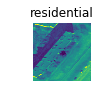

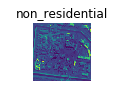

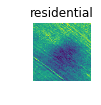

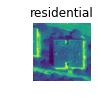

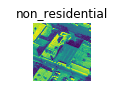

In [9]:
# Sample a minibatch and show the images and captions
size = 5
indices = np.random.choice(len(train_set), size, replace=False)

fig = plt.figure()

for i in indices:
    image, label = train_set[i]
    ax = plt.subplot(1, size, i + 1)
    plt.tight_layout()
    ax.set_title(params['rbc_class_names'][label])
    ax.axis('off')
    image = np.moveaxis(image, 0, -1)
    plt.imshow(image[:,:,0])

    if i == size:
        plt.show()
        break

## Load Model
Load in pre-trained DenseNet. Configure training parameters. 

### Naive two-layer CNN

In [10]:
model = DenseNetEfficient(
        growth_rate=32, 
        block_config=(6, 12, 24, 16), 
        compression=0.5,
        num_init_features=64, 
        bn_size=4, 
        drop_rate=0,
        num_classes=2, 
        small_inputs=False)
# Move model to GPU
model = model.cuda()
print(model)


DenseNetEfficient(
  (features): Sequential(
    (conv0): Conv2d (1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (bn): _EfficientDensenetBottleneck(
        )
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (bn): _EfficientDensenetBottleneck(
        )
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer3): _DenseLayer(
        (bn): _

/home/feng/anaconda3/envs/rbc_env/lib/python3.6/site-packages/torch/nn/modules/container.py:13: UserWarning: nn.Container is deprecated. All of it's functionality is now implemented in nn.Module. Subclass that instead.
  warnings.warn("nn.Container is deprecated. All of it's functionality "


## Train Model
Train the model one epoch at a time. Keep the verbose option on to monitor the loss during training. 
Save training and validation accuracy history for visualization. 

In [11]:
train(model, 
      train_set, 
      test_set, 
      '/home/feng/ext2/feng/workspace/residential_building_challenge/output', 
      n_epochs=50, 
      valid_size=0,
      batch_size=50, 
      lr=0.1, 
      wd=0.0001, 
      momentum=0.9, 
      seed=None)

Epoch: [1/50]	Iter: [1/24]	Time 0.556 (0.556)	Loss 0.6789 (0.6789)	Error 0.3000 (0.3000)
Epoch: [1/50]	Iter: [2/24]	Time 0.547 (0.551)	Loss 0.9070 (0.7929)	Error 0.5400 (0.4200)
Epoch: [1/50]	Iter: [3/24]	Time 0.533 (0.545)	Loss 1.1303 (0.9054)	Error 0.4600 (0.4333)
Epoch: [1/50]	Iter: [4/24]	Time 0.533 (0.542)	Loss 1.4186 (1.0337)	Error 0.5000 (0.4500)
Epoch: [1/50]	Iter: [5/24]	Time 0.534 (0.541)	Loss 1.4887 (1.1247)	Error 0.4200 (0.4440)
Epoch: [1/50]	Iter: [6/24]	Time 0.534 (0.540)	Loss 0.7785 (1.0670)	Error 0.6000 (0.4700)
Epoch: [1/50]	Iter: [7/24]	Time 0.534 (0.539)	Loss 0.9187 (1.0458)	Error 0.6200 (0.4914)
Epoch: [1/50]	Iter: [8/24]	Time 0.533 (0.538)	Loss 0.7577 (1.0098)	Error 0.5400 (0.4975)
Epoch: [1/50]	Iter: [9/24]	Time 0.533 (0.538)	Loss 1.0299 (1.0120)	Error 0.4000 (0.4867)
Epoch: [1/50]	Iter: [10/24]	Time 0.534 (0.537)	Loss 0.7144 (0.9823)	Error 0.6200 (0.5000)
Epoch: [1/50]	Iter: [11/24]	Time 0.534 (0.537)	Loss 0.7007 (0.9567)	Error 0.4800 (0.4982)
Epoch: [1/50]	Iter:

Epoch: [4/50]	Iter: [13/24]	Time 0.537 (0.537)	Loss 0.7764 (0.6182)	Error 0.3400 (0.3292)
Epoch: [4/50]	Iter: [14/24]	Time 0.537 (0.537)	Loss 0.6353 (0.6194)	Error 0.3200 (0.3286)
Epoch: [4/50]	Iter: [15/24]	Time 0.537 (0.537)	Loss 0.6634 (0.6223)	Error 0.3800 (0.3320)
Epoch: [4/50]	Iter: [16/24]	Time 0.537 (0.537)	Loss 0.7242 (0.6287)	Error 0.5400 (0.3450)
Epoch: [4/50]	Iter: [17/24]	Time 0.539 (0.537)	Loss 0.6299 (0.6288)	Error 0.4000 (0.3482)
Epoch: [4/50]	Iter: [18/24]	Time 0.541 (0.537)	Loss 0.6308 (0.6289)	Error 0.3400 (0.3478)
Epoch: [4/50]	Iter: [19/24]	Time 0.540 (0.537)	Loss 0.5956 (0.6271)	Error 0.3200 (0.3463)
Epoch: [4/50]	Iter: [20/24]	Time 0.540 (0.538)	Loss 0.6940 (0.6305)	Error 0.4200 (0.3500)
Epoch: [4/50]	Iter: [21/24]	Time 0.540 (0.538)	Loss 0.6839 (0.6330)	Error 0.4400 (0.3543)
Epoch: [4/50]	Iter: [22/24]	Time 0.540 (0.538)	Loss 0.6861 (0.6354)	Error 0.4600 (0.3591)
Epoch: [4/50]	Iter: [23/24]	Time 0.540 (0.538)	Loss 0.5702 (0.6326)	Error 0.2800 (0.3557)
Epoch: [4/

Test	Iter: [2/3]	Time 0.136 (0.136)	Loss 0.6561 (0.7068)	Error 0.3600 (0.3900)
Test	Iter: [3/3]	Time 0.136 (0.136)	Loss 0.7355 (0.7164)	Error 0.4200 (0.4000)
Epoch: [8/50]	Iter: [1/24]	Time 0.556 (0.556)	Loss 0.5264 (0.5264)	Error 0.2600 (0.2600)
Epoch: [8/50]	Iter: [2/24]	Time 0.557 (0.556)	Loss 0.5860 (0.5562)	Error 0.2600 (0.2600)
Epoch: [8/50]	Iter: [3/24]	Time 0.556 (0.556)	Loss 0.5877 (0.5667)	Error 0.3000 (0.2733)
Epoch: [8/50]	Iter: [4/24]	Time 0.557 (0.556)	Loss 0.4903 (0.5476)	Error 0.2200 (0.2600)
Epoch: [8/50]	Iter: [5/24]	Time 0.556 (0.556)	Loss 0.6945 (0.5770)	Error 0.3200 (0.2720)
Epoch: [8/50]	Iter: [6/24]	Time 0.557 (0.556)	Loss 0.5812 (0.5777)	Error 0.2800 (0.2733)
Epoch: [8/50]	Iter: [7/24]	Time 0.557 (0.556)	Loss 0.6307 (0.5853)	Error 0.3800 (0.2886)
Epoch: [8/50]	Iter: [8/24]	Time 0.557 (0.556)	Loss 0.5261 (0.5779)	Error 0.2800 (0.2875)
Epoch: [8/50]	Iter: [9/24]	Time 0.556 (0.556)	Loss 0.6470 (0.5856)	Error 0.3600 (0.2956)
Epoch: [8/50]	Iter: [10/24]	Time 0.557 (0

Epoch: [11/50]	Iter: [11/24]	Time 0.563 (0.562)	Loss 0.5077 (0.5190)	Error 0.3400 (0.2855)
Epoch: [11/50]	Iter: [12/24]	Time 0.563 (0.562)	Loss 0.5810 (0.5242)	Error 0.2800 (0.2850)
Epoch: [11/50]	Iter: [13/24]	Time 0.563 (0.562)	Loss 0.5516 (0.5263)	Error 0.3000 (0.2862)
Epoch: [11/50]	Iter: [14/24]	Time 0.563 (0.562)	Loss 0.5465 (0.5277)	Error 0.3400 (0.2900)
Epoch: [11/50]	Iter: [15/24]	Time 0.563 (0.563)	Loss 0.6059 (0.5329)	Error 0.3800 (0.2960)
Epoch: [11/50]	Iter: [16/24]	Time 0.563 (0.563)	Loss 0.5037 (0.5311)	Error 0.2400 (0.2925)
Epoch: [11/50]	Iter: [17/24]	Time 0.562 (0.563)	Loss 0.5095 (0.5298)	Error 0.2400 (0.2894)
Epoch: [11/50]	Iter: [18/24]	Time 0.563 (0.563)	Loss 0.6252 (0.5351)	Error 0.3000 (0.2900)
Epoch: [11/50]	Iter: [19/24]	Time 0.562 (0.563)	Loss 0.5069 (0.5337)	Error 0.2600 (0.2884)
Epoch: [11/50]	Iter: [20/24]	Time 0.562 (0.563)	Loss 0.4926 (0.5316)	Error 0.2400 (0.2860)
Epoch: [11/50]	Iter: [21/24]	Time 0.563 (0.563)	Loss 0.5506 (0.5325)	Error 0.2600 (0.2848)

Epoch: [14/50]	Iter: [22/24]	Time 0.563 (0.561)	Loss 0.5748 (0.5402)	Error 0.3400 (0.2755)
Epoch: [14/50]	Iter: [23/24]	Time 0.563 (0.561)	Loss 0.6023 (0.5429)	Error 0.4200 (0.2817)
Epoch: [14/50]	Iter: [24/24]	Time 0.563 (0.562)	Loss 0.5544 (0.5434)	Error 0.2600 (0.2808)
Test	Iter: [1/3]	Time 0.137 (0.137)	Loss 0.6936 (0.6936)	Error 0.4000 (0.4000)
Test	Iter: [2/3]	Time 0.137 (0.137)	Loss 0.5684 (0.6310)	Error 0.3000 (0.3500)
Test	Iter: [3/3]	Time 0.136 (0.137)	Loss 0.6651 (0.6424)	Error 0.4000 (0.3667)
Epoch: [15/50]	Iter: [1/24]	Time 0.560 (0.560)	Loss 0.4975 (0.4975)	Error 0.2400 (0.2400)
Epoch: [15/50]	Iter: [2/24]	Time 0.563 (0.562)	Loss 0.5389 (0.5182)	Error 0.3400 (0.2900)
Epoch: [15/50]	Iter: [3/24]	Time 0.563 (0.562)	Loss 0.4129 (0.4831)	Error 0.2400 (0.2733)
Epoch: [15/50]	Iter: [4/24]	Time 0.563 (0.562)	Loss 0.4446 (0.4735)	Error 0.2000 (0.2550)
Epoch: [15/50]	Iter: [5/24]	Time 0.562 (0.562)	Loss 0.4931 (0.4774)	Error 0.3000 (0.2640)
Epoch: [15/50]	Iter: [6/24]	Time 0.562 (

Epoch: [18/50]	Iter: [6/24]	Time 0.559 (0.560)	Loss 0.5200 (0.4480)	Error 0.2400 (0.2267)
Epoch: [18/50]	Iter: [7/24]	Time 0.558 (0.559)	Loss 0.6091 (0.4710)	Error 0.3200 (0.2400)
Epoch: [18/50]	Iter: [8/24]	Time 0.560 (0.560)	Loss 0.3311 (0.4535)	Error 0.1600 (0.2300)
Epoch: [18/50]	Iter: [9/24]	Time 0.559 (0.559)	Loss 0.5815 (0.4677)	Error 0.3400 (0.2422)
Epoch: [18/50]	Iter: [10/24]	Time 0.560 (0.560)	Loss 0.5155 (0.4725)	Error 0.2400 (0.2420)
Epoch: [18/50]	Iter: [11/24]	Time 0.560 (0.560)	Loss 0.6253 (0.4864)	Error 0.2600 (0.2436)
Epoch: [18/50]	Iter: [12/24]	Time 0.560 (0.560)	Loss 0.4405 (0.4826)	Error 0.2200 (0.2417)
Epoch: [18/50]	Iter: [13/24]	Time 0.560 (0.560)	Loss 0.5902 (0.4909)	Error 0.2600 (0.2431)
Epoch: [18/50]	Iter: [14/24]	Time 0.561 (0.560)	Loss 0.5221 (0.4931)	Error 0.2600 (0.2443)
Epoch: [18/50]	Iter: [15/24]	Time 0.561 (0.560)	Loss 0.4839 (0.4925)	Error 0.2400 (0.2440)
Epoch: [18/50]	Iter: [16/24]	Time 0.560 (0.560)	Loss 0.3604 (0.4842)	Error 0.2000 (0.2412)
Epo

Epoch: [21/50]	Iter: [17/24]	Time 0.559 (0.560)	Loss 0.3868 (0.5014)	Error 0.1200 (0.2482)
Epoch: [21/50]	Iter: [18/24]	Time 0.559 (0.560)	Loss 0.4755 (0.4999)	Error 0.2200 (0.2467)
Epoch: [21/50]	Iter: [19/24]	Time 0.559 (0.560)	Loss 0.4638 (0.4980)	Error 0.1800 (0.2432)
Epoch: [21/50]	Iter: [20/24]	Time 0.560 (0.560)	Loss 0.3882 (0.4925)	Error 0.2000 (0.2410)
Epoch: [21/50]	Iter: [21/24]	Time 0.559 (0.560)	Loss 0.2785 (0.4823)	Error 0.1000 (0.2343)
Epoch: [21/50]	Iter: [22/24]	Time 0.560 (0.560)	Loss 0.3615 (0.4768)	Error 0.2200 (0.2336)
Epoch: [21/50]	Iter: [23/24]	Time 0.560 (0.560)	Loss 0.5205 (0.4787)	Error 0.2200 (0.2330)
Epoch: [21/50]	Iter: [24/24]	Time 0.560 (0.560)	Loss 0.3831 (0.4748)	Error 0.1800 (0.2308)
Test	Iter: [1/3]	Time 0.136 (0.136)	Loss 1.0601 (1.0601)	Error 0.3600 (0.3600)
Test	Iter: [2/3]	Time 0.136 (0.136)	Loss 0.5428 (0.8014)	Error 0.3000 (0.3300)
Test	Iter: [3/3]	Time 0.136 (0.136)	Loss 0.9275 (0.8435)	Error 0.4000 (0.3533)
Epoch: [22/50]	Iter: [1/24]	Time 0.

Epoch: [25/50]	Iter: [1/24]	Time 0.558 (0.558)	Loss 0.5304 (0.5304)	Error 0.2400 (0.2400)
Epoch: [25/50]	Iter: [2/24]	Time 0.560 (0.559)	Loss 0.4052 (0.4678)	Error 0.2400 (0.2400)
Epoch: [25/50]	Iter: [3/24]	Time 0.560 (0.559)	Loss 0.4452 (0.4603)	Error 0.2200 (0.2333)
Epoch: [25/50]	Iter: [4/24]	Time 0.560 (0.559)	Loss 0.2612 (0.4105)	Error 0.1200 (0.2050)
Epoch: [25/50]	Iter: [5/24]	Time 0.560 (0.560)	Loss 0.4490 (0.4182)	Error 0.2000 (0.2040)
Epoch: [25/50]	Iter: [6/24]	Time 0.559 (0.560)	Loss 0.3764 (0.4112)	Error 0.1800 (0.2000)
Epoch: [25/50]	Iter: [7/24]	Time 0.560 (0.560)	Loss 0.5896 (0.4367)	Error 0.2800 (0.2114)
Epoch: [25/50]	Iter: [8/24]	Time 0.560 (0.560)	Loss 0.4912 (0.4435)	Error 0.2600 (0.2175)
Epoch: [25/50]	Iter: [9/24]	Time 0.560 (0.560)	Loss 0.4488 (0.4441)	Error 0.2400 (0.2200)
Epoch: [25/50]	Iter: [10/24]	Time 0.559 (0.560)	Loss 0.4632 (0.4460)	Error 0.2000 (0.2180)
Epoch: [25/50]	Iter: [11/24]	Time 0.560 (0.560)	Loss 0.3398 (0.4364)	Error 0.2000 (0.2164)
Epoch: [

Epoch: [28/50]	Iter: [12/24]	Time 0.561 (0.560)	Loss 0.2433 (0.2702)	Error 0.1200 (0.1150)
Epoch: [28/50]	Iter: [13/24]	Time 0.560 (0.560)	Loss 0.3160 (0.2737)	Error 0.1200 (0.1154)
Epoch: [28/50]	Iter: [14/24]	Time 0.559 (0.560)	Loss 0.2357 (0.2710)	Error 0.1000 (0.1143)
Epoch: [28/50]	Iter: [15/24]	Time 0.560 (0.560)	Loss 0.4680 (0.2842)	Error 0.2200 (0.1213)
Epoch: [28/50]	Iter: [16/24]	Time 0.559 (0.560)	Loss 0.3204 (0.2864)	Error 0.1400 (0.1225)
Epoch: [28/50]	Iter: [17/24]	Time 0.559 (0.560)	Loss 0.2898 (0.2866)	Error 0.2000 (0.1271)
Epoch: [28/50]	Iter: [18/24]	Time 0.559 (0.560)	Loss 0.3301 (0.2890)	Error 0.1400 (0.1278)
Epoch: [28/50]	Iter: [19/24]	Time 0.559 (0.560)	Loss 0.2142 (0.2851)	Error 0.1000 (0.1263)
Epoch: [28/50]	Iter: [20/24]	Time 0.560 (0.560)	Loss 0.2981 (0.2858)	Error 0.1400 (0.1270)
Epoch: [28/50]	Iter: [21/24]	Time 0.560 (0.560)	Loss 0.4667 (0.2944)	Error 0.2800 (0.1343)
Epoch: [28/50]	Iter: [22/24]	Time 0.560 (0.560)	Loss 0.2063 (0.2904)	Error 0.0600 (0.1309)

Epoch: [31/50]	Iter: [23/24]	Time 0.561 (0.561)	Loss 0.2222 (0.2595)	Error 0.1000 (0.1235)
Epoch: [31/50]	Iter: [24/24]	Time 0.560 (0.561)	Loss 0.2834 (0.2605)	Error 0.1000 (0.1225)
Test	Iter: [1/3]	Time 0.136 (0.136)	Loss 0.6116 (0.6116)	Error 0.3000 (0.3000)
Test	Iter: [2/3]	Time 0.136 (0.136)	Loss 0.4704 (0.5410)	Error 0.1800 (0.2400)
Test	Iter: [3/3]	Time 0.136 (0.136)	Loss 0.6193 (0.5671)	Error 0.2400 (0.2400)
Epoch: [32/50]	Iter: [1/24]	Time 0.558 (0.558)	Loss 0.1578 (0.1578)	Error 0.0400 (0.0400)
Epoch: [32/50]	Iter: [2/24]	Time 0.560 (0.559)	Loss 0.1785 (0.1682)	Error 0.0600 (0.0500)
Epoch: [32/50]	Iter: [3/24]	Time 0.560 (0.559)	Loss 0.2127 (0.1830)	Error 0.1000 (0.0667)
Epoch: [32/50]	Iter: [4/24]	Time 0.560 (0.559)	Loss 0.2346 (0.1959)	Error 0.1200 (0.0800)
Epoch: [32/50]	Iter: [5/24]	Time 0.560 (0.560)	Loss 0.1445 (0.1856)	Error 0.0600 (0.0760)
Epoch: [32/50]	Iter: [6/24]	Time 0.560 (0.560)	Loss 0.1525 (0.1801)	Error 0.0200 (0.0667)
Epoch: [32/50]	Iter: [7/24]	Time 0.560 (0

Epoch: [35/50]	Iter: [7/24]	Time 0.556 (0.556)	Loss 0.0881 (0.1719)	Error 0.0000 (0.0657)
Epoch: [35/50]	Iter: [8/24]	Time 0.556 (0.556)	Loss 0.1971 (0.1751)	Error 0.1000 (0.0700)
Epoch: [35/50]	Iter: [9/24]	Time 0.556 (0.556)	Loss 0.1935 (0.1771)	Error 0.0800 (0.0711)
Epoch: [35/50]	Iter: [10/24]	Time 0.557 (0.556)	Loss 0.1023 (0.1696)	Error 0.0000 (0.0640)
Epoch: [35/50]	Iter: [11/24]	Time 0.557 (0.556)	Loss 0.1497 (0.1678)	Error 0.0600 (0.0636)
Epoch: [35/50]	Iter: [12/24]	Time 0.556 (0.556)	Loss 0.2096 (0.1713)	Error 0.1400 (0.0700)
Epoch: [35/50]	Iter: [13/24]	Time 0.556 (0.556)	Loss 0.2385 (0.1765)	Error 0.1000 (0.0723)
Epoch: [35/50]	Iter: [14/24]	Time 0.556 (0.556)	Loss 0.1923 (0.1776)	Error 0.0800 (0.0729)
Epoch: [35/50]	Iter: [15/24]	Time 0.556 (0.556)	Loss 0.2264 (0.1808)	Error 0.1400 (0.0773)
Epoch: [35/50]	Iter: [16/24]	Time 0.556 (0.556)	Loss 0.2553 (0.1855)	Error 0.1400 (0.0813)
Epoch: [35/50]	Iter: [17/24]	Time 0.556 (0.556)	Loss 0.1777 (0.1850)	Error 0.0800 (0.0812)
Ep

Epoch: [38/50]	Iter: [18/24]	Time 0.559 (0.558)	Loss 0.1571 (0.1226)	Error 0.0600 (0.0533)
Epoch: [38/50]	Iter: [19/24]	Time 0.559 (0.558)	Loss 0.1605 (0.1246)	Error 0.0800 (0.0547)
Epoch: [38/50]	Iter: [20/24]	Time 0.558 (0.558)	Loss 0.1392 (0.1253)	Error 0.0800 (0.0560)
Epoch: [38/50]	Iter: [21/24]	Time 0.559 (0.558)	Loss 0.3259 (0.1349)	Error 0.1600 (0.0610)
Epoch: [38/50]	Iter: [22/24]	Time 0.559 (0.558)	Loss 0.0760 (0.1322)	Error 0.0400 (0.0600)
Epoch: [38/50]	Iter: [23/24]	Time 0.559 (0.558)	Loss 0.1968 (0.1350)	Error 0.1200 (0.0626)
Epoch: [38/50]	Iter: [24/24]	Time 0.558 (0.558)	Loss 0.2412 (0.1394)	Error 0.1000 (0.0642)
Test	Iter: [1/3]	Time 0.136 (0.136)	Loss 0.4843 (0.4843)	Error 0.2200 (0.2200)
Test	Iter: [2/3]	Time 0.136 (0.136)	Loss 0.5304 (0.5074)	Error 0.1200 (0.1700)
Test	Iter: [3/3]	Time 0.136 (0.136)	Loss 0.7530 (0.5893)	Error 0.2800 (0.2067)
Epoch: [39/50]	Iter: [1/24]	Time 0.557 (0.557)	Loss 0.1839 (0.1839)	Error 0.0600 (0.0600)
Epoch: [39/50]	Iter: [2/24]	Time 0.5

Epoch: [42/50]	Iter: [2/24]	Time 0.559 (0.558)	Loss 0.0399 (0.0526)	Error 0.0200 (0.0200)
Epoch: [42/50]	Iter: [3/24]	Time 0.560 (0.559)	Loss 0.0673 (0.0575)	Error 0.0200 (0.0200)
Epoch: [42/50]	Iter: [4/24]	Time 0.559 (0.559)	Loss 0.0714 (0.0610)	Error 0.0200 (0.0200)
Epoch: [42/50]	Iter: [5/24]	Time 0.559 (0.559)	Loss 0.0714 (0.0630)	Error 0.0400 (0.0240)
Epoch: [42/50]	Iter: [6/24]	Time 0.559 (0.559)	Loss 0.0573 (0.0621)	Error 0.0000 (0.0200)
Epoch: [42/50]	Iter: [7/24]	Time 0.559 (0.559)	Loss 0.0907 (0.0662)	Error 0.0400 (0.0229)
Epoch: [42/50]	Iter: [8/24]	Time 0.559 (0.559)	Loss 0.0924 (0.0694)	Error 0.0200 (0.0225)
Epoch: [42/50]	Iter: [9/24]	Time 0.559 (0.559)	Loss 0.0678 (0.0693)	Error 0.0200 (0.0222)
Epoch: [42/50]	Iter: [10/24]	Time 0.559 (0.559)	Loss 0.0945 (0.0718)	Error 0.0200 (0.0220)
Epoch: [42/50]	Iter: [11/24]	Time 0.559 (0.559)	Loss 0.1104 (0.0753)	Error 0.0200 (0.0218)
Epoch: [42/50]	Iter: [12/24]	Time 0.559 (0.559)	Loss 0.1291 (0.0798)	Error 0.0600 (0.0250)
Epoch: 

Epoch: [45/50]	Iter: [13/24]	Time 0.559 (0.559)	Loss 0.1725 (0.0737)	Error 0.0600 (0.0200)
Epoch: [45/50]	Iter: [14/24]	Time 0.559 (0.559)	Loss 0.1134 (0.0765)	Error 0.0600 (0.0229)
Epoch: [45/50]	Iter: [15/24]	Time 0.559 (0.559)	Loss 0.0221 (0.0729)	Error 0.0000 (0.0213)
Epoch: [45/50]	Iter: [16/24]	Time 0.559 (0.559)	Loss 0.0634 (0.0723)	Error 0.0000 (0.0200)
Epoch: [45/50]	Iter: [17/24]	Time 0.559 (0.559)	Loss 0.0526 (0.0711)	Error 0.0200 (0.0200)
Epoch: [45/50]	Iter: [18/24]	Time 0.559 (0.559)	Loss 0.1121 (0.0734)	Error 0.0400 (0.0211)
Epoch: [45/50]	Iter: [19/24]	Time 0.559 (0.559)	Loss 0.0350 (0.0714)	Error 0.0000 (0.0200)
Epoch: [45/50]	Iter: [20/24]	Time 0.559 (0.559)	Loss 0.0326 (0.0694)	Error 0.0000 (0.0190)
Epoch: [45/50]	Iter: [21/24]	Time 0.559 (0.559)	Loss 0.0529 (0.0686)	Error 0.0200 (0.0190)
Epoch: [45/50]	Iter: [22/24]	Time 0.559 (0.559)	Loss 0.0342 (0.0671)	Error 0.0000 (0.0182)
Epoch: [45/50]	Iter: [23/24]	Time 0.559 (0.559)	Loss 0.0269 (0.0653)	Error 0.0000 (0.0174)

Epoch: [48/50]	Iter: [24/24]	Time 0.559 (0.559)	Loss 0.0706 (0.0557)	Error 0.0000 (0.0158)
Test	Iter: [1/3]	Time 0.136 (0.136)	Loss 0.6155 (0.6155)	Error 0.2200 (0.2200)
Test	Iter: [2/3]	Time 0.136 (0.136)	Loss 0.5031 (0.5593)	Error 0.1800 (0.2000)
Test	Iter: [3/3]	Time 0.136 (0.136)	Loss 0.6047 (0.5744)	Error 0.1600 (0.1867)
Epoch: [49/50]	Iter: [1/24]	Time 0.557 (0.557)	Loss 0.0628 (0.0628)	Error 0.0200 (0.0200)
Epoch: [49/50]	Iter: [2/24]	Time 0.559 (0.558)	Loss 0.0620 (0.0624)	Error 0.0200 (0.0200)
Epoch: [49/50]	Iter: [3/24]	Time 0.559 (0.559)	Loss 0.0176 (0.0475)	Error 0.0000 (0.0133)
Epoch: [49/50]	Iter: [4/24]	Time 0.559 (0.559)	Loss 0.0389 (0.0453)	Error 0.0000 (0.0100)
Epoch: [49/50]	Iter: [5/24]	Time 0.559 (0.559)	Loss 0.0300 (0.0422)	Error 0.0000 (0.0080)
Epoch: [49/50]	Iter: [6/24]	Time 0.559 (0.559)	Loss 0.0562 (0.0446)	Error 0.0200 (0.0100)
Epoch: [49/50]	Iter: [7/24]	Time 0.558 (0.559)	Loss 0.0300 (0.0425)	Error 0.0000 (0.0086)
Epoch: [49/50]	Iter: [8/24]	Time 0.559 (0.

## Visualization
Visualize training and validation accuracy throughout training history. 
Visualize loss function. 

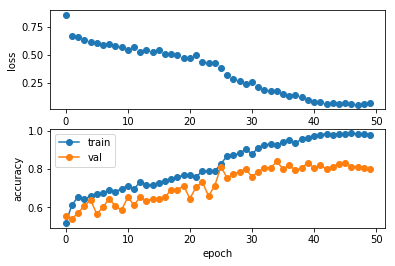

In [22]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

with open(os.path.join('/home/feng/ext2/feng/workspace/residential_building_challenge/output', 'results.csv'), 'r') as f:
        for line in f:
            numbers = line.split(',')
            if(numbers[0]=='epoch'):
                continue
            try:
                train_loss.append(float(numbers[1]))
                train_acc.append(1-float(numbers[2]))
                valid_loss.append(float(numbers[3]))
                valid_acc.append(1-float(numbers[4]))
            except ValueError:
                continue


# Visualize loss history and training/validation accuracy history
plt.subplot(2, 1, 1)
plt.plot(train_loss, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc, '-o')
plt.plot(valid_acc, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Test Model
Make predictions based on test dataset. Visually assess the quality of prediction and compute accuracy based on groundtruth. 

In [33]:
# Check accuracy of model on Test set
test_acc = check_accuracy(model, loader_test)
print("Test Accuracy: %.3f" % test_acc)

Got 7 / 12 correct (58.33)
Test Accuracy: 0.583


### Visualize Successful and Failed Examples

In [63]:
x = np.array([[1,2],[2,3],[3,4]])
mask = [False,False,True]
print(x)

[[1 2]
 [2 3]
 [3 4]]


In [41]:
X_success = np.array([]).reshape((0, 1, 200, 200))
y_success = np.array([]).reshape((0,))
X_failure = np.array([]).reshape((0, 1, 200, 200))
y_failure = np.array([]).reshape((0,))

model.eval() 
for X, y in loader_test:
    X_var = Variable(X.type(dtype), volatile=True)
    scores = model(X_var)
    _, preds = scores.data.cpu().max(1)
    idx_success = (preds == y).numpy() == 1
    idx_failure = (preds != y).numpy() == 1
    X = X.numpy()
    y = y.numpy()
    X_success = np.append(X_success, X[idx_success.tolist(), :, :, :], axis=0)
    y_success = np.append(y_success, y[idx_success.tolist(), ], axis=0)
    X_failure = np.append(X_failure, X[idx_failure.tolist(), :, :, :], axis=0)
    y_failure = np.append(y_failure, preds[idx_failure.tolist(), ], axis=0)
    
y_success = y_success.astype(np.int32)
y_failure = y_failure.astype(np.int32)

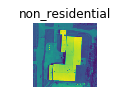

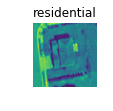

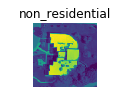

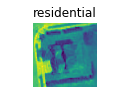

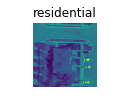

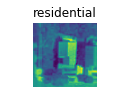

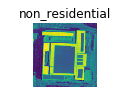

IndexError: index 7 is out of bounds for axis 0 with size 7

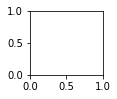

In [35]:
# Sample a batch of successfully classified images
for i in range(12):
    plt.subplot(3, 4, i+1)
    img = np.moveaxis(X_success[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_success[i]])
    plt.show()

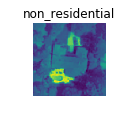

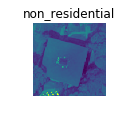

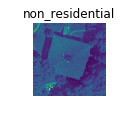

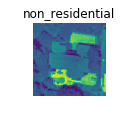

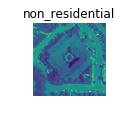

IndexError: index 5 is out of bounds for axis 0 with size 5

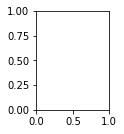

In [42]:
# Sample a batch of incorrectly classified images
plt.title('Failure Examples')
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = np.moveaxis(X_failure[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_failure[i]])
    plt.show()

## Save Model

In [85]:
# Save the Trained Model
torch.save(model.state_dict(), 'cnn.pkl')